<a href="https://colab.research.google.com/github/kwjj0820/AIGroupProject/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install h3 geopandas osmnx xgboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 27.7 MB/s eta 0:00:00


**최종 코드**

In [5]:
import os
import warnings
import folium
import geopandas as gpd
import h3
import numpy as np
import optuna
import osmnx as ox
import pandas as pd
import xgboost as xgb
from scipy.spatial import cKDTree
from scipy.stats import spearmanr
from shapely.geometry import Point, mapping
from shapely.prepared import prep
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import BallTree
from tqdm import tqdm

# 기본 설정
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)


class FloatingPopTimeSeriesAnalysis:
    """
    - main_file: 견인 데이터 (엑셀)
    - pop_file : 유동인구 데이터 (CSV)
    - h3_res   : H3 해상도
    """

    def __init__(self, main_file, pop_file, h3_res=9, cache_dir="env_data_cache"):
        self.main_file = main_file
        self.pop_file = pop_file
        self.cache_dir = cache_dir
        self.h3_res = h3_res

        self.poi_data = {}
        self.gdf_edges = None
        self.G = None

        self.best_model = None
        self.best_params = {}
        self.eval_results = {}

        self.pop_source_data = None

        self.X_test = None
        self.y_test = None
        self.y_real_count = None
        self.y_log = None
        self.y_test_real = None

        self.period_str = "All_Period"

        os.makedirs(cache_dir, exist_ok=True)

    # 데이터 로딩
    def load_data(self, start_date=None, end_date=None):
        """견인 데이터 + 유동인구 데이터 로드 및 기간 필터링."""
        print("데이터 로드 및 기간 필터링")

        # 1. 견인 데이터
        if not os.path.exists(self.main_file):
            raise FileNotFoundError(f"파일 없음: {self.main_file}")

        self.df = pd.read_excel(self.main_file)

        if start_date and end_date:
            self.period_str = f"{start_date}~{end_date}"
        else:
            self.period_str = "All_Period"

        date_col = "신고일"
        if date_col in self.df.columns:
            self.df[date_col] = pd.to_datetime(self.df[date_col])
            self.df = self.df.sort_values(date_col).reset_index(drop=True)

            if start_date:
                self.df = self.df[self.df[date_col] >= start_date]
            if end_date:
                self.df = self.df[self.df[date_col] <= end_date]

            print(f"견인 데이터 건수: {len(self.df):,d}건")

        # 2. 유동인구 데이터
        df_pop_raw = pd.read_csv(self.pop_file)
        pop_date_col = "측정시간"

        if pop_date_col in df_pop_raw.columns:
            try:
                # 날짜 형식
                df_pop_raw[pop_date_col] = pd.to_datetime(
                    df_pop_raw[pop_date_col].astype(str),
                    format="%Y%m%d",
                )

                if start_date:
                    df_pop_raw = df_pop_raw[df_pop_raw[pop_date_col] >= start_date]
                if end_date:
                    df_pop_raw = df_pop_raw[df_pop_raw[pop_date_col] <= end_date]

                print(f"유동인구 기간 필터링 완료: {len(df_pop_raw):,d}건")
            except Exception as e:
                print(f"유동인구 날짜 변환 실패: {e}")
        else:
            print(f"유동인구 파일에 '{pop_date_col}' 컬럼이 없습니다.")

        # 좌표 없는 행 제거
        df_pop_clean = df_pop_raw.dropna(subset=["위도", "경도"])

        # IDW용 센서 위치별 평균 방문자수
        self.pop_source_data = (
            df_pop_clean.groupby(["위도", "경도"])["방문자수"].mean().reset_index()
        )
        print(f"유동인구 센서(Source) 위치: {len(self.pop_source_data)}개")

    # OSM/POI/도로망 로딩
    def load_env_data(self):
        print("POI 및 도로망 데이터 로드")

        tags = {
            "bus": {"highway": "bus_stop"},
            "subway": {"railway": "station"},
            "school": {"amenity": "school"},
            "cafe": {"amenity": "cafe"},
            "store": {"shop": "convenience"},
            "crosswalk": {"highway": "crossing"},
        }

        def load_poi(name, tag):
            fname = os.path.join(self.cache_dir, f"seoul_{name}.geojson")
            if os.path.exists(fname):
                return gpd.read_file(fname)

            try:
                gdf = ox.features_from_place("Seoul, South Korea", tags=tag)
                if "geometry" in gdf.columns:
                    points = gdf[gdf.geometry.type == "Point"][["geometry"]]
                    points.to_file(fname, driver="GeoJSON")
                    return points
            except Exception:
                pass

            return gpd.GeoDataFrame()

        # POI
        for name, tag in tags.items():
            self.poi_data[name] = load_poi(name, tag)

        # 도로망
        road_file = os.path.join(self.cache_dir, "seoul_roads.graphml")
        if os.path.exists(road_file):
            self.G = ox.load_graphml(road_file)
            self.gdf_edges = ox.graph_to_gdfs(self.G, nodes=False, edges=True)
        else:
            try:
                self.G = ox.graph_from_place("Seoul, South Korea", network_type="drive")
                ox.save_graphml(self.G, road_file)
                self.gdf_edges = ox.graph_to_gdfs(self.G, nodes=False, edges=True)
            except Exception:
                self.gdf_edges = gpd.GeoDataFrame()

    # 내부 계산 유틸 함수들
    @staticmethod
    def _calc_road(hex_list, edges, res):
        """각 H3 셀별 도로 길이 합계."""
        if edges is None or len(edges) == 0:
            return [0] * len(hex_list)

        edges = edges.copy()
        edges["h3"] = edges.apply(
            lambda x: h3.latlng_to_cell(
                x.geometry.centroid.y, x.geometry.centroid.x, res
            ),
            axis=1,
        )
        road_dict = edges.groupby("h3")["length"].sum().to_dict()
        return [road_dict.get(h, 0) for h in hex_list]

    @staticmethod
    def _calc_dist(hex_list, target_gdf):
        """각 H3 셀에서 가장 가까운 POI까지 거리(미터)"""
        if len(target_gdf) == 0:
            return [0] * len(hex_list)

        coords = [h3.cell_to_latlng(h) for h in hex_list]
        src = np.radians(np.array(coords))
        tgt = np.radians(np.array([(p.y, p.x) for p in target_gdf.geometry]))

        tree = BallTree(tgt, metric="haversine")
        dists, _ = tree.query(src, k=1)
        return (dists.flatten() * 6371000).tolist()

    @staticmethod
    def _calc_imp(hex_list, target_gdf, res, decay=0.5, desc="POI 영향도"):
        """주변 H3 셀까지 고려한 POI 영향도"""
        if len(target_gdf) == 0:
            return [0] * len(hex_list)

        p_h3 = [
            h3.latlng_to_cell(r.geometry.y, r.geometry.x, res)
            for _, r in target_gdf.iterrows()
        ]
        p_cnt = pd.Series(p_h3).value_counts().to_dict()

        results = []
        for h in tqdm(hex_list, desc=desc):
            s = 0.0
            try:
                neighbors = h3.grid_disk(h, 1)
            except Exception:
                neighbors = h3.k_ring(h, 1)

            for n in neighbors:
                c = p_cnt.get(n, 0)
                if c > 0:
                    s += c * (1.0 if n == h else decay)
            results.append(s)

        return results

    # 피처 생성 + IDW 보간
    def create_features(self):
        print(f"변수 생성 및 IDW 보간 적용 (Resolution {self.h3_res})")

        # 서울 폴리곤
        seoul_gdf = ox.geocode_to_gdf("Seoul, South Korea")
        seoul_poly = seoul_gdf.geometry.values[0]

        # H3 그리드 생성
        try:
            hexes = list(h3.polyfill(mapping(seoul_poly), self.h3_res))
        except Exception:
            # polyfill 실패 시: bounding box 기반 샘플링
            min_x, min_y, max_x, max_y = seoul_poly.bounds
            step = 0.001 * (9 / self.h3_res)
            lats = np.arange(min_y, max_y, step)
            lngs = np.arange(min_x, max_x, step)

            final_cells = set()
            prepared_geom = prep(seoul_poly)

            for lat in lats:
                for lng in lngs:
                    if prepared_geom.contains(Point(lng, lat)):
                        final_cells.add(
                            h3.latlng_to_cell(lat, lng, self.h3_res)
                        )

            hexes = list(final_cells)

        target_df = pd.DataFrame({"h3": hexes})
        target_df["count"] = 0

        # 견인 건수 집계
        self.df["h3"] = self.df.apply(
            lambda x: h3.latlng_to_cell(x["lat"], x["lng"], self.h3_res),
            axis=1,
        )
        real_counts = self.df["h3"].value_counts().reset_index()
        real_counts.columns = ["h3", "real_count"]

        target_df = target_df.merge(real_counts, on="h3", how="left")
        target_df["count"] = target_df["real_count"].fillna(0)
        target_df["y_log"] = np.log1p(target_df["count"])

        self.y_real_count = target_df["count"]
        self.y_log = target_df["y_log"]

        # 환경 변수 계산
        self.model_df = pd.DataFrame({"h3": hexes})
        print("기본 환경 변수(도로/POI) 계산")

        self.model_df["road_density"] = self._calc_road(
            hexes, self.gdf_edges, self.h3_res
        )
        self.model_df["dist_subway"] = self._calc_dist(
            hexes, self.poi_data.get("subway", gpd.GeoDataFrame())
        )
        self.model_df["dist_school"] = self._calc_dist(
            hexes, self.poi_data.get("school", gpd.GeoDataFrame())
        )
        self.model_df["dist_cross"] = self._calc_dist(
            hexes, self.poi_data.get("crosswalk", gpd.GeoDataFrame())
        )
        self.model_df["imp_bus"] = self._calc_imp(
            hexes,
            self.poi_data.get("bus", gpd.GeoDataFrame()),
            self.h3_res,
            decay=0.3,
            desc="버스 영향도",
        )
        self.model_df["imp_cafe"] = self._calc_imp(
            hexes,
            self.poi_data.get("cafe", gpd.GeoDataFrame()),
            self.h3_res,
            decay=0.5,
            desc="카페 영향도",
        )
        self.model_df["imp_store"] = self._calc_imp(
            hexes,
            self.poi_data.get("store", gpd.GeoDataFrame()),
            self.h3_res,
            decay=0.5,
            desc="편의점 영향도",
        )

        # IDW 유동인구 보간
        print("유동인구 IDW 보간")
        source_coords = self.pop_source_data[["위도", "경도"]].values
        source_values = self.pop_source_data["방문자수"].values
        target_coords = np.array([h3.cell_to_latlng(h) for h in hexes])

        tree = cKDTree(source_coords)
        dists, idxs = tree.query(target_coords, k=5)
        weights = 1.0 / (dists + 1e-6) ** 2
        weights /= weights.sum(axis=1)[:, None]

        interpolated_pop = np.sum(weights * source_values[idxs], axis=1)
        self.model_df["floating_pop"] = np.log1p(interpolated_pop)

        self.features = [
            "road_density",
            "dist_subway",
            "dist_school",
            "dist_cross",
            "imp_bus",
            "imp_cafe",
            "imp_store",
            "floating_pop",
        ]

    # 평가 지표 계산
    def evaluate_advanced_metrics(self):
        print("\n[추가 검증] 지표")
        if self.best_model is None:
            return

        pred_log = self.best_model.predict(self.X_test)
        pred_real = np.expm1(pred_log)
        y_real = self.y_test_real

        # 음수 예측 방지
        pred_real = np.where(pred_real < 0, 0, pred_real)

        final_r2 = r2_score(self.y_test, pred_log)
        mae = mean_absolute_error(y_real, pred_real)
        rho, _ = spearmanr(y_real, pred_real)

        # 상위 20% 평가
        k = max(int(len(y_real) * 0.2), 1)

        actual_top_k_indices = set(y_real.nlargest(k).index)
        predicted_top_k_indices = set(
            pd.Series(pred_real, index=y_real.index).nlargest(k).index
        )
        intersection_size = len(actual_top_k_indices & predicted_top_k_indices)

        precision_at_k = intersection_size / k * 100
        recall_at_k = intersection_size / k * 100

        self.eval_results = {
            "R2": final_r2,
            "MAE": mae,
            "Rho": rho,
            "Precision@20%": precision_at_k,
            "Recall@20%": recall_at_k,
        }

        print("=" * 60)
        print(f"1. R2 Score (Log)     : {final_r2:.4f}")
        print(f"2. MAE (평균오차)      : {mae:.2f}대")
        print(f"3. Spearman Rho (순위): {rho:.4f}")
        print(f"4. Precision@20%      : {precision_at_k:.1f}%")
        print(f"5. Recall@20%         : {recall_at_k:.1f}%")
        print("=" * 60)

    # 지도 시각화
    def visualize_all_grids(self, n_trials=0, custom_name=None):
        if self.best_model is None:
            return

        self.model_df["pred_count"] = np.expm1(
            self.best_model.predict(self.model_df[self.features])
        )

        sample_h3 = self.model_df["h3"].iloc[0]
        lat, lng = h3.cell_to_latlng(sample_h3)

        m = folium.Map(location=[lat, lng], zoom_start=11, tiles="cartodbpositron")

        plot_df = self.model_df[self.model_df["pred_count"] >= 0.5]

        if not plot_df.empty:
            vmin = plot_df["pred_count"].min()
            vmax = plot_df["pred_count"].quantile(0.95)

            colormap = folium.LinearColormap(
                ["yellow", "orange", "red"],
                vmin=vmin,
                vmax=vmax,
                caption="예측 대수",
            )
            colormap.add_to(m)

            for _, row in tqdm(plot_df.iterrows(), total=len(plot_df)):
                try:
                    folium.Polygon(
                        locations=h3.cell_to_boundary(row["h3"]),
                        popup=f"Hex: {row['h3']}<br>예측: {row['pred_count']:.1f}",
                        color=None,
                        fill=True,
                        fill_color=colormap(row["pred_count"]),
                        fill_opacity=0.6,
                    ).add_to(m)
                except Exception:
                    pass

        filename = f"Risk_Map_{custom_name}.html"
        m.save(filename)
        print(f"지도 저장: {filename}")



# 시계열 검증 + Optuna 튜닝
if __name__ == "__main__":
    main_file = "/content/drive/MyDrive/kickboarddata/서울시_전동킥보드_견인현황_좌표_결측치제거(21.7~25.6).xlsx"
    pop_file = "/content/drive/MyDrive/kickboarddata/유동인구데이터.csv"
    h3_res = 8

    n_trials = 50

    validation_periods = [
        ("2021-07-01", "2022-06-30", "2022-07-01", "2023-06-30"),
        ("2021-07-01", "2023-06-30", "2023-07-01", "2024-06-30"),
        ("2021-07-01", "2024-06-30", "2024-07-01", "2025-06-30"),
    ]

    final_report = []

    if os.path.exists(main_file) and os.path.exists(pop_file):
        print("\n" + "=" * 80)
        print("시계열 검증 시작")
        print("=" * 80)

        for i, (train_start, train_end, test_start, test_end) in enumerate(
            validation_periods, 1
        ):
            period_name = f"{test_start[:4]}.{test_start[5:7]}~{test_end[:4]}.{test_end[5:7]}"
            print(f"\n[Round {i}] 예측 구간: {period_name}")

            # 1) 학습 데이터 준비
            train_model = FloatingPopTimeSeriesAnalysis(
                main_file, pop_file, h3_res=h3_res
            )
            train_model.load_data(start_date=train_start, end_date=train_end)

            if len(train_model.df) < 1000:
                continue

            train_model.load_env_data()
            train_model.create_features()

            print(f"Optuna Trials = {n_trials}")

            X = train_model.model_df[train_model.features]
            y = train_model.y_log

            # 80% / 20% 분할
            split_idx = int(len(X) * 0.8)
            X_tr_opt = X.iloc[:split_idx]
            y_tr_opt = y.iloc[:split_idx]

            def objective(trial):
                # XGBoost 하이퍼파라미터 탐색
                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
                    "learning_rate": trial.suggest_float(
                        "learning_rate", 0.005, 0.1
                    ),
                    "max_depth": trial.suggest_int("max_depth", 3, 9),
                    "min_child_weight": trial.suggest_int(
                        "min_child_weight", 1, 7
                    ),
                    "gamma": trial.suggest_float("gamma", 0, 5),
                    "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                    "colsample_bytree": trial.suggest_float(
                        "colsample_bytree", 0.6, 1.0
                    ),
                    "n_jobs": -1,
                    "random_state": 42,
                }

                model = xgb.XGBRegressor(**param)

                # 시계열 교차검증
                tscv = TimeSeriesSplit(n_splits=3)
                scores = []

                for tr_idx, val_idx in tscv.split(X_tr_opt):
                    X_tr_fold = X_tr_opt.iloc[tr_idx]
                    y_tr_fold = y_tr_opt.iloc[tr_idx]
                    X_val_fold = X_tr_opt.iloc[val_idx]
                    y_val_fold = y_tr_opt.iloc[val_idx]

                    model.fit(X_tr_fold, y_tr_fold)
                    pred = model.predict(X_val_fold)

                    rho, _ = spearmanr(
                        np.expm1(y_val_fold),
                        np.expm1(pred),
                    )
                    scores.append(rho)

                return np.mean(scores)

            study = optuna.create_study(direction="maximize")
            study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

            print(f"최적 파라미터: {study.best_params}")

            # 최적 파라미터로 모델 재학습
            train_model.best_params = study.best_params
            train_model.best_model = xgb.XGBRegressor(
                **study.best_params, n_jobs=-1, random_state=42
            )
            train_model.best_model.fit(X_tr_opt, y_tr_opt)

            # 2) 테스트 구간 평가
            test_model = FloatingPopTimeSeriesAnalysis(
                main_file, pop_file, h3_res=h3_res
            )
            test_model.load_data(start_date=test_start, end_date=test_end)

            if len(test_model.df) == 0:
                continue

            test_model.load_env_data()
            test_model.create_features()

            # 학습된 모델 그대로 이식
            test_model.best_model = train_model.best_model
            test_model.features = train_model.features
            test_model.best_params = train_model.best_params

            test_model.X_test = test_model.model_df[test_model.features]
            test_model.y_test = test_model.y_log
            test_model.y_test_real = test_model.y_real_count

            test_model.evaluate_advanced_metrics()

            # 결과 수집
            res = test_model.eval_results
            res["Period"] = period_name
            res["Train_Range"] = f"~{train_end}"
            final_report.append(res)


        # 전체 결과 요약
        print("\n" + "=" * 80)
        print("최종 성능 평가")
        print("=" * 80)

        df_res = pd.DataFrame(final_report)
        if not df_res.empty:
            cols = [
                "Period",
                "Rho",
                "Precision@20%",
                "Recall@20%",
                "MAE",
                "R2",
                "Train_Range",
            ]
            print(df_res[cols].to_string(index=False))

            print("-" * 80)
            print(f"전체 평균 Spearman Rho : {df_res['Rho'].mean():.4f}")
            print(f"전체 평균 Precision@20%: {df_res['Precision@20%'].mean():.1f}%")
            print(f"전체 평균 Recall@20%  : {df_res['Recall@20%'].mean():.1f}%")
            print(f"전체 평균 MAE (오차)  : {df_res['MAE'].mean():.2f}대")
        else:
            print("결과 데이터가 없습니다.")

    else:
        print("입력 파일을 찾을 수 없습니다.")


시계열 검증 시작

[Round 1] 예측 구간: 2022.07~2023.06
데이터 로드 및 기간 필터링
견인 데이터 건수: 53,978건
유동인구 기간 필터링 완료: 14,616건
유동인구 센서(Source) 위치: 99개
POI 및 도로망 데이터 로드
변수 생성 및 IDW 보간 적용 (Resolution 8)
기본 환경 변수(도로/POI) 계산


편의점 영향도: 100%|██████████| 1314/1314 [00:00<00:00, 56375.40it/s]

유동인구 IDW 보간
Optuna Trials = 50


  0%|          | 0/50 [00:00<?, ?it/s]

최적 파라미터: {'n_estimators': 479, 'learning_rate': 0.030986586075675566, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 2.871054376190523, 'subsample': 0.9879960126624242, 'colsample_bytree': 0.8273074028999927}
데이터 로드 및 기간 필터링
견인 데이터 건수: 56,411건
유동인구 기간 필터링 완료: 28,684건
유동인구 센서(Source) 위치: 105개
POI 및 도로망 데이터 로드
변수 생성 및 IDW 보간 적용 (Resolution 8)
기본 환경 변수(도로/POI) 계산


편의점 영향도: 100%|██████████| 1314/1314 [00:00<00:00, 95094.82it/s]


유동인구 IDW 보간

[추가 검증] 지표
1. R2 Score (Log)     : 0.7162
2. MAE (평균오차)      : 31.37대
3. Spearman Rho (순위): 0.8455
4. Precision@20%      : 61.1%
5. Recall@20%         : 61.1%

[Round 2] 예측 구간: 2023.07~2024.06
데이터 로드 및 기간 필터링
견인 데이터 건수: 110,389건
유동인구 기간 필터링 완료: 43,300건
유동인구 센서(Source) 위치: 107개
POI 및 도로망 데이터 로드
변수 생성 및 IDW 보간 적용 (Resolution 8)
기본 환경 변수(도로/POI) 계산


편의점 영향도: 100%|██████████| 1314/1314 [00:00<00:00, 89913.13it/s]

유동인구 IDW 보간
Optuna Trials = 50


  0%|          | 0/50 [00:00<?, ?it/s]

최적 파라미터: {'n_estimators': 570, 'learning_rate': 0.07229259040530159, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 1.690017544357992, 'subsample': 0.7489123547016294, 'colsample_bytree': 0.8124984510085367}
데이터 로드 및 기간 필터링
견인 데이터 건수: 73,491건
유동인구 기간 필터링 완료: 28,201건
유동인구 센서(Source) 위치: 106개
POI 및 도로망 데이터 로드
변수 생성 및 IDW 보간 적용 (Resolution 8)
기본 환경 변수(도로/POI) 계산


편의점 영향도: 100%|██████████| 1314/1314 [00:00<00:00, 48660.31it/s]


유동인구 IDW 보간

[추가 검증] 지표
1. R2 Score (Log)     : 0.7391
2. MAE (평균오차)      : 36.89대
3. Spearman Rho (순위): 0.8660
4. Precision@20%      : 63.7%
5. Recall@20%         : 63.7%

[Round 3] 예측 구간: 2024.07~2025.06
데이터 로드 및 기간 필터링
견인 데이터 건수: 183,880건
유동인구 기간 필터링 완료: 71,501건
유동인구 센서(Source) 위치: 107개
POI 및 도로망 데이터 로드
변수 생성 및 IDW 보간 적용 (Resolution 8)
기본 환경 변수(도로/POI) 계산


편의점 영향도: 100%|██████████| 1314/1314 [00:00<00:00, 101985.85it/s]

유동인구 IDW 보간
Optuna Trials = 50


  0%|          | 0/50 [00:00<?, ?it/s]

최적 파라미터: {'n_estimators': 547, 'learning_rate': 0.019709180533228024, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 1.4248824277153946, 'subsample': 0.8070842603823923, 'colsample_bytree': 0.6342294113921818}
데이터 로드 및 기간 필터링
견인 데이터 건수: 81,933건
유동인구 기간 필터링 완료: 34,109건
유동인구 센서(Source) 위치: 101개
POI 및 도로망 데이터 로드
변수 생성 및 IDW 보간 적용 (Resolution 8)
기본 환경 변수(도로/POI) 계산


편의점 영향도: 100%|██████████| 1314/1314 [00:00<00:00, 67987.21it/s]

유동인구 IDW 보간

[추가 검증] 지표
1. R2 Score (Log)     : 0.6989
2. MAE (평균오차)      : 60.86대
3. Spearman Rho (순위): 0.8509
4. Precision@20%      : 56.1%
5. Recall@20%         : 56.1%

최종 성능 평가
         Period      Rho  Precision@20%  Recall@20%       MAE       R2 Train_Range
2022.07~2023.06 0.845533      61.068702   61.068702 31.369183 0.716192 ~2022-06-30
2023.07~2024.06 0.865950      63.740458   63.740458 36.890761 0.739093 ~2023-06-30
2024.07~2025.06 0.850941      56.106870   56.106870 60.864417 0.698871 ~2024-06-30
--------------------------------------------------------------------------------
전체 평균 Spearman Rho : 0.8541
전체 평균 Precision@20%: 60.3%
전체 평균 Recall@20%  : 60.3%
전체 평균 MAE (오차)  : 43.04대


**feature importance 시각화**

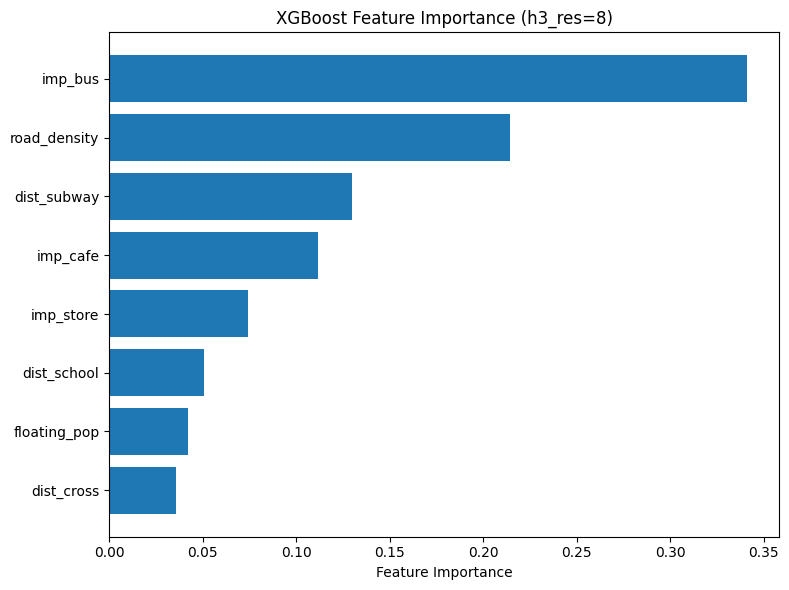

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

target_model = train_model

if target_model.best_model is None:
    print("학습된 모델이 존재하지 않습니다.")
else:
    importances = target_model.best_model.feature_importances_
    fi = (
        pd.DataFrame({
            "feature": target_model.features,
            "importance": importances
        })
        .sort_values("importance", ascending=True)
    )

    plt.figure(figsize=(8, 6))
    plt.barh(fi["feature"], fi["importance"])
    plt.xlabel("Feature Importance")
    plt.title(f"XGBoost Feature Importance (h3_res={target_model.h3_res})")
    plt.tight_layout()
    plt.show()

**h3 시각화**

In [7]:
import pandas as pd
import numpy as np
import folium
from folium import LinearColormap
from tqdm import tqdm
import os


# 학습된 모델 사용
model = test_model

# H3 그리드 준비
if not hasattr(model, "model_df"):
    raise ValueError("선행 학습된 모델이 없습니다.")

hex_df = model.model_df.copy()

if "h3" not in hex_df.columns:
    raise ValueError("모델에 'h3' 컬럼이 없습니다.")

# 실제 견인 건수 H3 집계
if "h3" not in model.df.columns:
    if {"lat", "lng"}.issubset(model.df.columns):
        print("H3 인덱스")
        model.df["h3"] = model.df.apply(
            lambda x: h3.latlng_to_cell(x["lat"], x["lng"], model.h3_res),
            axis=1
        )
    else:
        raise ValueError("모델에 'lat', 'lng' 컬럼이 없습니다.")

towing_counts = (
    model.df["h3"]
    .value_counts()
    .rename_axis("h3")
    .reset_index(name="towing_count")
)

hex_df = hex_df.merge(towing_counts, on="h3", how="left")
hex_df["towing_count"] = hex_df["towing_count"].fillna(0)

# 예측 견인 건수 생성
if model.best_model is None:
    raise ValueError("선행 학습된 모델이 없습니다.")

hex_df["pred_count"] = np.expm1(
    model.best_model.predict(hex_df[model.features])
)

# 지도 초기 위치
sample_hex = hex_df["h3"].iloc[0]
center_lat, center_lng = h3.cell_to_latlng(sample_hex)

m = folium.Map(location=[center_lat, center_lng], zoom_start=11, tiles="cartodbpositron")

# 레이어 추가 함수
def add_layer(map_obj, df, column, layer_name, colors, hide_zero=False):

    layer_df = df[["h3", column]].copy().dropna()

    if hide_zero:
        layer_df = layer_df[layer_df[column] > 0]

    if layer_df.empty:
        print(f"'{layer_name}' 레이어에 표시할 데이터 없음")
        return

    vals = layer_df[column].astype(float).values
    vmin = np.quantile(vals, 0.05)
    vmax = np.quantile(vals, 0.95)
    if vmin == vmax:
        vmin = vals.min()
        vmax = vals.max() if vals.max() > vals.min() else vals.min() + 1e-6

    cmap = LinearColormap(colors, vmin=vmin, vmax=vmax, caption=layer_name)
    fg = folium.FeatureGroup(name=layer_name, show=True)

    for _, row in tqdm(layer_df.iterrows(), total=len(layer_df), desc=layer_name):
        h = row["h3"]
        value = float(row[column])
        try:
            boundary = h3.cell_to_boundary(h)
            folium.Polygon(
                locations=[(lat, lng) for lat, lng in boundary],
                popup=f"{layer_name}: {value:.2f}",
                color=None,
                fill=True,
                fill_color=cmap(value),
                fill_opacity=0.7,
            ).add_to(fg)
        except Exception:
            continue

    cmap.add_to(map_obj)
    fg.add_to(map_obj)

# 실제 / 예측 시각화
add_layer(
    m,
    hex_df,
    column="towing_count",
    layer_name="실제 견인 건수",
    colors=["#deebf7", "#9ecae1", "#08519c"],
    hide_zero=True
)

add_layer(
    m,
    hex_df,
    column="pred_count",
    layer_name="예측 견인 건수",
    colors=["#fee5d9", "#fcae91", "#cb181d"],
    hide_zero=False
)

folium.LayerControl(collapsed=False).add_to(m)

# 저장 경로
save_path = f"/content/h3_res_{model.h3_res}_real_vs_pred.html"
m.save(save_path)
print("저장 위치:", save_path)

예측 견인 건수: 100%|██████████| 1314/1314 [00:00<00:00, 5840.34it/s]


저장 위치: /content/h3_res_8_real_vs_pred.html
